In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from az_utils import make_line_plot_v1

%load_ext autoreload
%autoreload 2

---------------------

### Assumed irrigation efficiencies

Harquahala Irrigation Non-Expansion Area - 0.75

Douglas Active Management Area - 0.85



# model version = V19 (for Arizona Only)

-----------------------

# Harquahala INA, Arizona

In [2]:
ann_df = pd.read_csv('../../Data_main/AZ_files/results_eval/netGW/hqr/hqr_annual.csv')
ann_df['sim_mean_pumping_mm'] = ann_df['mean netGW_mm'] / 0.75

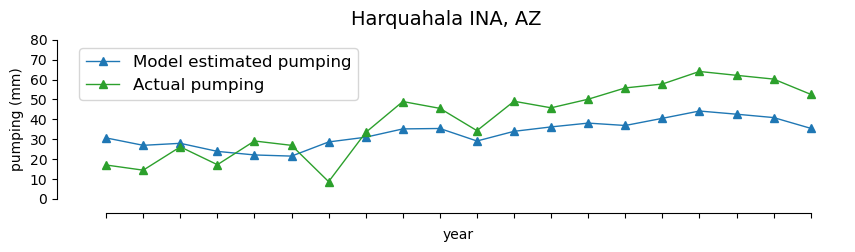

In [3]:
year = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


make_line_plot_v1(y1=ann_df['sim_mean_pumping_mm'], y2=ann_df['mean pumping_mm'], year=year, fontsize=14, 
                  xlabel='year', ylabel='pumping (mm)', 
                  line_label_1='Model estimated pumping', line_label_2='Actual pumping',
                  suptitle='Harquahala INA, AZ', y_lim=(0, 80), 
                  figsize=(10, 3), legend_pos='upper left', legend='on', savepath= None, no_xticks=True)

------------------

# Douglas AMA, Arizona

In [4]:
ann_df = pd.read_csv('../../Data_main/AZ_files/results_eval/netGW/doug/doug_annual.csv')
ann_df['sim_mean_pumping_mm'] = ann_df['mean netGW_mm'] / 0.85

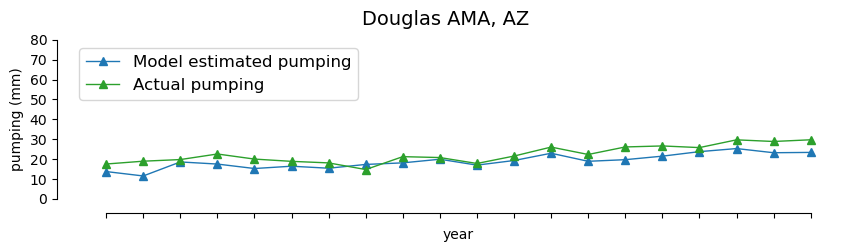

In [5]:
year = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


make_line_plot_v1(y1=ann_df['sim_mean_pumping_mm'], y2=ann_df['mean pumping_mm'], year=year, fontsize=14, 
                  xlabel='year', ylabel='pumping (mm)', 
                  line_label_1='Model estimated pumping', line_label_2='Actual pumping',
                  suptitle='Douglas AMA, AZ', y_lim=(0, 80), 
                  figsize=(10, 3), legend_pos='upper left', legend='on', savepath= None, no_xticks=True)

----------

# Animation creation code

In [18]:
import os
import rasterio
import numpy as np
from glob import glob
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

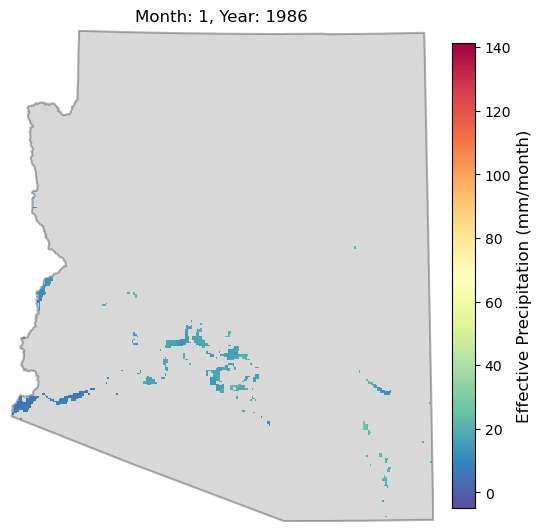

In [20]:
az_gdf = gpd.read_file('../../Data_main/AZ_files/ref_files/AZ.shp')

Peff_dir = '../../Data_main/AZ_files/rasters/Effective_precip_prediction_WestUS/v19_monthly_scaled'

# loading all TIFF files (sorted)
tiff_files = []
for yr in list(range(1986, 2022)):
    for month in range(1, 13):
        peff = glob(os.path.join(Peff_dir, f'*{yr}_{month}.tif'))[0]
        tiff_files.append(peff)

        
# Compute global min/max
for i, tif in enumerate(tiff_files):
    with rasterio.open(tif) as src:
        img = src.read(1)
        img[img == src.nodata] = np.nan
        
        if i==0:
            global_min = np.nanmin(img)
            global_max = np.nanmax(img)
        else:
            global_min = min(global_min, np.nanmin(img))
            global_max = max(global_max, np.nanmax(img))
            
# making a base plot
with rasterio.open(tiff_files[0]) as src:
    img = src.read(1)
    img[img==src.nodata] = np.nan
    bounds = src.bounds  # Get raster extent
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top] 
    raster_crs = src.crs  # Get raster CRS

# creating figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xticks([])         # removes x axis
ax.set_yticks([])        # removes y axis
ax.set_frame_on(False)   # remove frame/border

# plotting az shapefile
if az_gdf.crs != raster_crs:
    az_gdf = az_gdf.to_crs(raster_crs)

az_gdf.plot(ax=ax, edgecolor='black', facecolor='grey', linewidth=1.5, alpha=0.3, zorder=1)

# plotting image
img_display = ax.imshow(img, cmap='Spectral_r', extent=extent, vmin=global_min, vmax=global_max, zorder=2)

cbar = plt.colorbar(img_display, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Effective Precipitation (mm/month)', fontsize=12)
plt.subplots_adjust(top=0.95)


# Function to update frames in animation
def update(frame):
    with rasterio.open(tiff_files[frame]) as src:
        month = os.path.basename(tiff_files[frame]).split('_')[-1].split('.')[0]
        year = os.path.basename(tiff_files[frame]).split('_')[-2]
        img = src.read(1)
        img[img == src.nodata] = np.nan  # Handle NoData values
        
    img_display.set_data(img)  # Update raster image
    ax.set_title(f"Month: {month}, Year: {year}")  # Set title
    
    return img_display,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(tiff_files), interval=5000, blit=False)
ani.save('./animation/Peff_animation.gif', writer='pillow', fps=4)

# Show animation
ani